# Find Cities with Climate like you Hometown in the World

If you have ever wondered which cities would have a similar climate to your hometown, you might be tempted to look up a world map of [climate zones](https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification). However, these climates are fairly broadly defined so cities with quite different climates can end up in the same zone. Also, due to the hard boundary between climate zones, border cities (like Frankfurt or Philadelphia) can have cities in a different climate zone that are more similar to them than others in their own zone. 
In this project we try to answer these questions using climate data from [Weatherbase.com](https://www.weatherbase.com/).

## Loading dataset
Note that in addition to the packages commonly used in data science, we will also use _metpy_ and _geopandas_, which can be easily installed with _pip_.

In [4]:
#Speedup for scikit-learn on Windows systems
from sklearnex import patch_sklearn
patch_sklearn()
#importing libraries
import numpy as np
import pandas as pd
from metpy.units import units
import metpy.calc as mpcalc
from tabulate import tabulate
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from utility_functions import *
sns.set()
%matplotlib inline

#import dataset
df = pd.read_csv('city_climate_dataframe.csv', low_memory=False) #units are SI
df.set_index('Key',inplace=True)
df.fillna(value={'State':''}, inplace=True)
#Load world map for plotting
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df.head()
#pd.set_option('display.max_columns', 500)
#df.describe()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


City State      Country Region  \
Key                                                                          
Afghanistan/'Alaqahdari Dishu  'Alaqahdari Dishu        Afghanistan   Asia   
Afghanistan/Aibak                          Aibak        Afghanistan   Asia   
Afghanistan/Anar Darah                Anar Darah        Afghanistan   Asia   
Afghanistan/Andkhoy                      Andkhoy        Afghanistan   Asia   
Afghanistan/Arghestan                  Arghestan        Afghanistan   Asia   

                                Latitude  Longitude  Elevation  \
Key                                                              
Afghanistan/'Alaqahdari Dishu  30.432060  63.298019   595.8840   
Afghanistan/Aibak              36.264679  68.015511   968.0448   
Afghanistan/Anar Darah         32.758701  61.653969   782.1168   
Afghanistan/Andkhoy            36.952930  65.123756   306.9336   
Afghanistan/Arghestan          31.559811  66.489258  1260.9576   

                               Average Temperature, month 1  \
Key                                                           
Afghanistan/'Alaqahdari Dishu                           8.7   
Afghanistan/Aibak                                      -0.4   
Afghanistan/Anar Darah                                  5.9   
Afghanistan/Andkhoy                                     3.6   
Afghanistan/Arghestan                                   4.5   

                               Average Temperature, month 2  \
Key                                                           
Afghanistan/'Alaqahdari Dishu                          11.8   
Afghanistan/Aibak                                       1.6   
Afghanistan/Anar Darah                                  8.4   
Afghanistan/Andkhoy                                     5.9   
Afghanistan/Arghestan                                   6.9   

                               Average Temperature, month 3  ...  \
Key                                                          ...   
Afghanistan/'Alaqahdari Dishu                          17.6  ...   
Afghanistan/Aibak                                       7.2  ...   
Afghanistan/Anar Darah                                 13.7  ...   
Afghanistan/Andkhoy                                    11.2  ...   
Afghanistan/Arghestan                                  12.4  ...   

                               Average Wind Speed, month 3  \
Key                                                          
Afghanistan/'Alaqahdari Dishu                         10.1   
Afghanistan/Aibak                                      9.0   
Afghanistan/Anar Darah                                11.2   
Afghanistan/Andkhoy                                   11.5   
Afghanistan/Arghestan                                 11.5   

                               Average Wind Speed, month 4  \
Key                                                          
Afghanistan/'Alaqahdari Dishu                          9.0   
Afghanistan/Aibak                                      8.3   
Afghanistan/Anar Darah                                10.4   
Afghanistan/Andkhoy                                   10.8   
Afghanistan/Arghestan                                  9.4   

                               Average Wind Speed, month 5  \
Key                                                          
Afghanistan/'Alaqahdari Dishu                          9.4   
Afghanistan/Aibak                                      8.6   
Afghanistan/Anar Darah                                11.2   
Afghanistan/Andkhoy                                   10.4   
Afghanistan/Arghestan                                  9.7   

                               Average Wind Speed, month 6  \
Key                                                          
Afghanistan/'Alaqahdari Dishu                         12.2   
Afghanistan/Aibak                                     11.5   
Afghanistan/Anar Darah                                12.2   
Afghanistan/Andkhoy                                   10.8

We can see that for every city we have 163 datapoints describing the different aspects of its climate (e.g., temperature, wind, humidity) on a monthly basis. This is significantly more information than what the standard [Köppen climate zone classification](https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification) uses.

While we have a lot of climate data for each city, we are missing perhaps the most important one, the **apparent temperature** (i.e., how hot/cold a human would feel). We can calculate it using _metpy_, it is a function of temperature, humidity and wind speed.

In [5]:
#Add average apparent temperature for each month
def apparent_temp(T, RH, vw):
    return np.array(mpcalc.apparent_temperature(np.array(T) * units.degC, np.array(RH) * units.percent, np.array(vw) * units.kilometer / (units.hour), mask_undefined = False ))
for i in range(1,13):
    df['Apparent Temperature, month %d'%(i)] = apparent_temp(df['Average Temperature, month %d'%(i)],\
                                                             df['Average Relative Humidity, month %d'%(i)],\
                                                             df['Average Wind Speed, month %d'%(i)])

## Normalizing data
First rule of any DS project is to normalize the data to put the different metrics on a more "equal footing". The usual practice is to use StandardScaler or MinMaxScaler, however both suffer from issues on this dataset. For min-max scaling the rare, extreme climates will dominate, so most locations would mostly cluster in a much smaller range (e.g., the highest yearly percipitation in the world is about 12000 mm, while most cities get between 0 and 1000). Standard scaling works a lot better, but that suffers from the opposite problem for columns where most cities are around the median but are still important (e.g., number of days with snow). So I decided to use a custom MinMax scaling based on the 10th and 90th percentiles to reduce tboth effects.

In [6]:
def percentile_scaler(arr, percentile_low = 10, percentile_high = 90, axis=0):
    low = np.nanpercentile(arr, percentile_low, axis = axis)
    median = np.nanpercentile(arr, 50, axis = axis)
    high = np.nanpercentile(arr, percentile_high, axis = axis)
    scale = high - low
    return (arr - median)/scale

#Drop unnecessary columns for reduced dataframe
df_red = df.copy()
df_red.drop(['City', 'State', 'Country', 'Region', 'Latitude', 'Longitude'], axis=1, inplace=True)

#Normalizing df
df_red_rescaled = percentile_scaler(df_red.copy())

## Rescaling
Looking at the column headers we can use some common sense to realize that some columns are more important than others. We can make them appear so for our calculations by rescaling them. Doing so in a DS project is always risky as one can very easily introduce biases. On the other hand, integrating domain knowledge can sometimes dramatically improve an algorithm.

In [7]:
app_temp_keys = ['Apparent Temperature, month %d'%(i) for i in range(1,13)]
avg_temp_keys = ['Average Temperature, month %d'%(i) for i in range(1,13)]
avg_prec_keys = ['Average Precipitation, month %d'%(i) for i in range(1,13)]
avg_humid_keys = ['Average Relative Humidity, month %d'%(i) for i in range(1,13)]
num_of_days_keys = [key for key in df.columns if 'Number of Days' in key]  
daytime_keys = [key for key in df.columns if ( ('Morning' in key) or ('Evening' in key))]

#Add extra weight to important columns
df_red_rescaled[app_temp_keys] *= 5
df_red_rescaled[avg_prec_keys] *= 2
#Lower weight to less important ones
df_red_rescaled[num_of_days_keys] *= 0.1
#Drop superflous/unimportant columns
df_red_rescaled.drop(avg_temp_keys,axis=1, inplace=True) #we will be using the apparent temperatures, so let's drop the original ones
df_red_rescaled.drop(daytime_keys,axis=1, inplace=True) #we are already using the daily averages

## Similarity/Distance between City Climates
If we want to quantify the similarity/distance between the climates of different locations we can use the Euclidean distance for that in our parameter space. Note that we can not use sklearn.metrics.pairwise_distances because we kept NaN values, which need to be handled. Here I use a dimension averaged distance using only dimensions which are non NaN in for both cities, but other alternatives could also work. It is important however that having NaN values should not necessarily make two cities more similar (hence the normalization by the number of dimensions).

In [8]:
def pairwise_distance(x,y):
    #Find non-NaN elements and take L2 distance between those, normalized by dimension
    non_nan_ind = np.isfinite(x) & np.isfinite(y)
    N = np.sum(non_nan_ind)
    return np.linalg.norm( x[non_nan_ind]-y[non_nan_ind] )/np.sqrt(N)

We can quickly test this with some European cities to see if what we get makes sense, i.e., the climate in Paris should be somewhat similar to other European cities but should differ significantly from Cairo or Moscow.

In [10]:
test_cities = ['Germany/Berlin', 'Russia/Moscow', 'United Kingdom/England/London',
               'United States of America/Massachusetts/Boston', 'United States of America/California/Los Angeles',
               'Austria/Vienna', 'Italy/Rome', 'Egypt/Cairo',
              ]
ref_city = 'France/Paris'
tab = []
for test_city in test_cities:
    dx1 = dist_between_keys(test_city, ref_city , df_red_rescaled)
    tab.append([test_city, dx1])
print(tabulate(tab,headers =['City','Climate distance to %s'%(ref_city)]))
    

City                                               Climate distance to France/Paris
-----------------------------------------------  ----------------------------------
Germany/Berlin                                                             0.319866
Russia/Moscow                                                              0.686279
United Kingdom/England/London                                              0.30342
United States of America/Massachusetts/Boston                              0.36103
United States of America/California/Los Angeles                            0.528939
Austria/Vienna                                                             0.18383
Italy/Rome                                                                 0.36599
Egypt/Cairo                                                                0.865264


We can also check in detail what columns are the main causes for differences between two cities and once again do a sanity check (i.e., LA is much warmer and less humid in the winter than Paris)

In [7]:
dist_between_keys('France/Paris', 'United States of America/California/Los Angeles' , df_red_rescaled, verbose=True);

Climate Parameter                      Distance
-----------------------------------  ----------
Apparent Temperature, month 11        -2.03046
Apparent Temperature, month 12        -1.84454
Apparent Temperature, month 1         -1.71809
Apparent Temperature, month 9         -1.52339
Apparent Temperature, month 2         -1.48279
Apparent Temperature, month 10        -1.46267
Apparent Temperature, month 3         -1.42241
Average Precipitation, month 2        -1.01778
Apparent Temperature, month 4         -0.991551
Apparent Temperature, month 8         -0.860856
Average Relative Humidity, month 12    0.828125
Average Relative Humidity, month 11    0.778146
Apparent Temperature, month 5         -0.748815
Average Relative Humidity, month 1     0.74344
Apparent Temperature, month 7         -0.691615


Now we can come back to our original question: _Which cities in the world have similar climates as my hometown?_
Since all cities are potential hometowns, we need to calculate the pairwise distances between all cities. This can take some time, so it is worth saving the results.

In [12]:
load_dist_mtx = True
fname = 'city_climate_dist_mtx_red.p'
overwrite_dist_mtx = False

if load_dist_mtx:
    if (not os.path.exists(fname)) or overwrite_dist_mtx:
        import time; start_time = time.perf_counter()
        print("Calculating distance matrix for dataframe, it will likely take about %g min"%( ((df_red.shape[0]/1000)**2) / 5))
        dist_mtx = calc_all_pairwise_distances(df_red)
        print('Saving distance matrix to '+fname)
        pickle_dump(fname,np.float32(dist_mtx), use_bz2=True) #convert to 32 bit floats to save space
        print("Calculation took %g minutes."%( (time.perf_counter() - start_time)/60 ))
    dist_mtx = pickle_load(fname, use_bz2=True)
    print('Distance matrix loaded from '+fname)

Distance matrix loaded from city_climate_dist_mtx_red.p


I am originally from Budapest, Hungary, but I live in the US. So let's see where in the North America would the weather be most similar.

In [8]:
#Function definition for world map plots
def climate_similarity_map(ref_key, distances, df, symbol_scale=2, palette='inferno', limits=None, scale=None, fname=None):
    if scale is None:
        dist_scale = 0.5
    elif isinstance(scale, str):
        dist_scale = 0.5 * distances[np.argmax(df.index==ref_key),np.argmax(df.index==scale)]
    else:
        dist_scale = scale
    dist_norm = np.clip( distances[np.argmax(df.index==ref_key),:] / dist_scale, 0, 1)
    fig, ax = plt.subplots(figsize=(20, 10),dpi=250)
    worldmap.plot(color="lightgrey", ax=ax)
    sns.scatterplot(data=df,x='Longitude',y='Latitude',hue=dist_norm, s=symbol_scale*(2+4/(dist_norm+0.02)), palette=palette ); 
    plt.legend([],[], frameon=False);
    if not (limits is None):
        if isinstance(limits, str):
            if limits=='North America':
                xlim = [-130,-60]; ylim = [20,55]
            elif limits=='US-East': 
                xlim = [-100,-50]; ylim = [25,55]
            elif limits=='US-West': 
                xlim = [-130,-100]; ylim = [20,55]
            elif limits=='Europe': 
                xlim = [-10,40]; ylim = [35,71]
            elif limits=='Asia': 
                xlim = [40,150]; ylim = [5,71] 
            elif limits=='Africa': 
                xlim = [-20,55]; ylim = [-35,40]
            if limits=='South America':
                xlim = [-90,-40]; ylim = [-60,20]
            if limits=='Oceania':
                xlim = [110,180]; ylim = [-50,0] 
        else:
            xlim = limits[0]; ylim = limits[1];
        plt.xlim(xlim); plt.ylim(ylim)
    if not(fname is None): plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

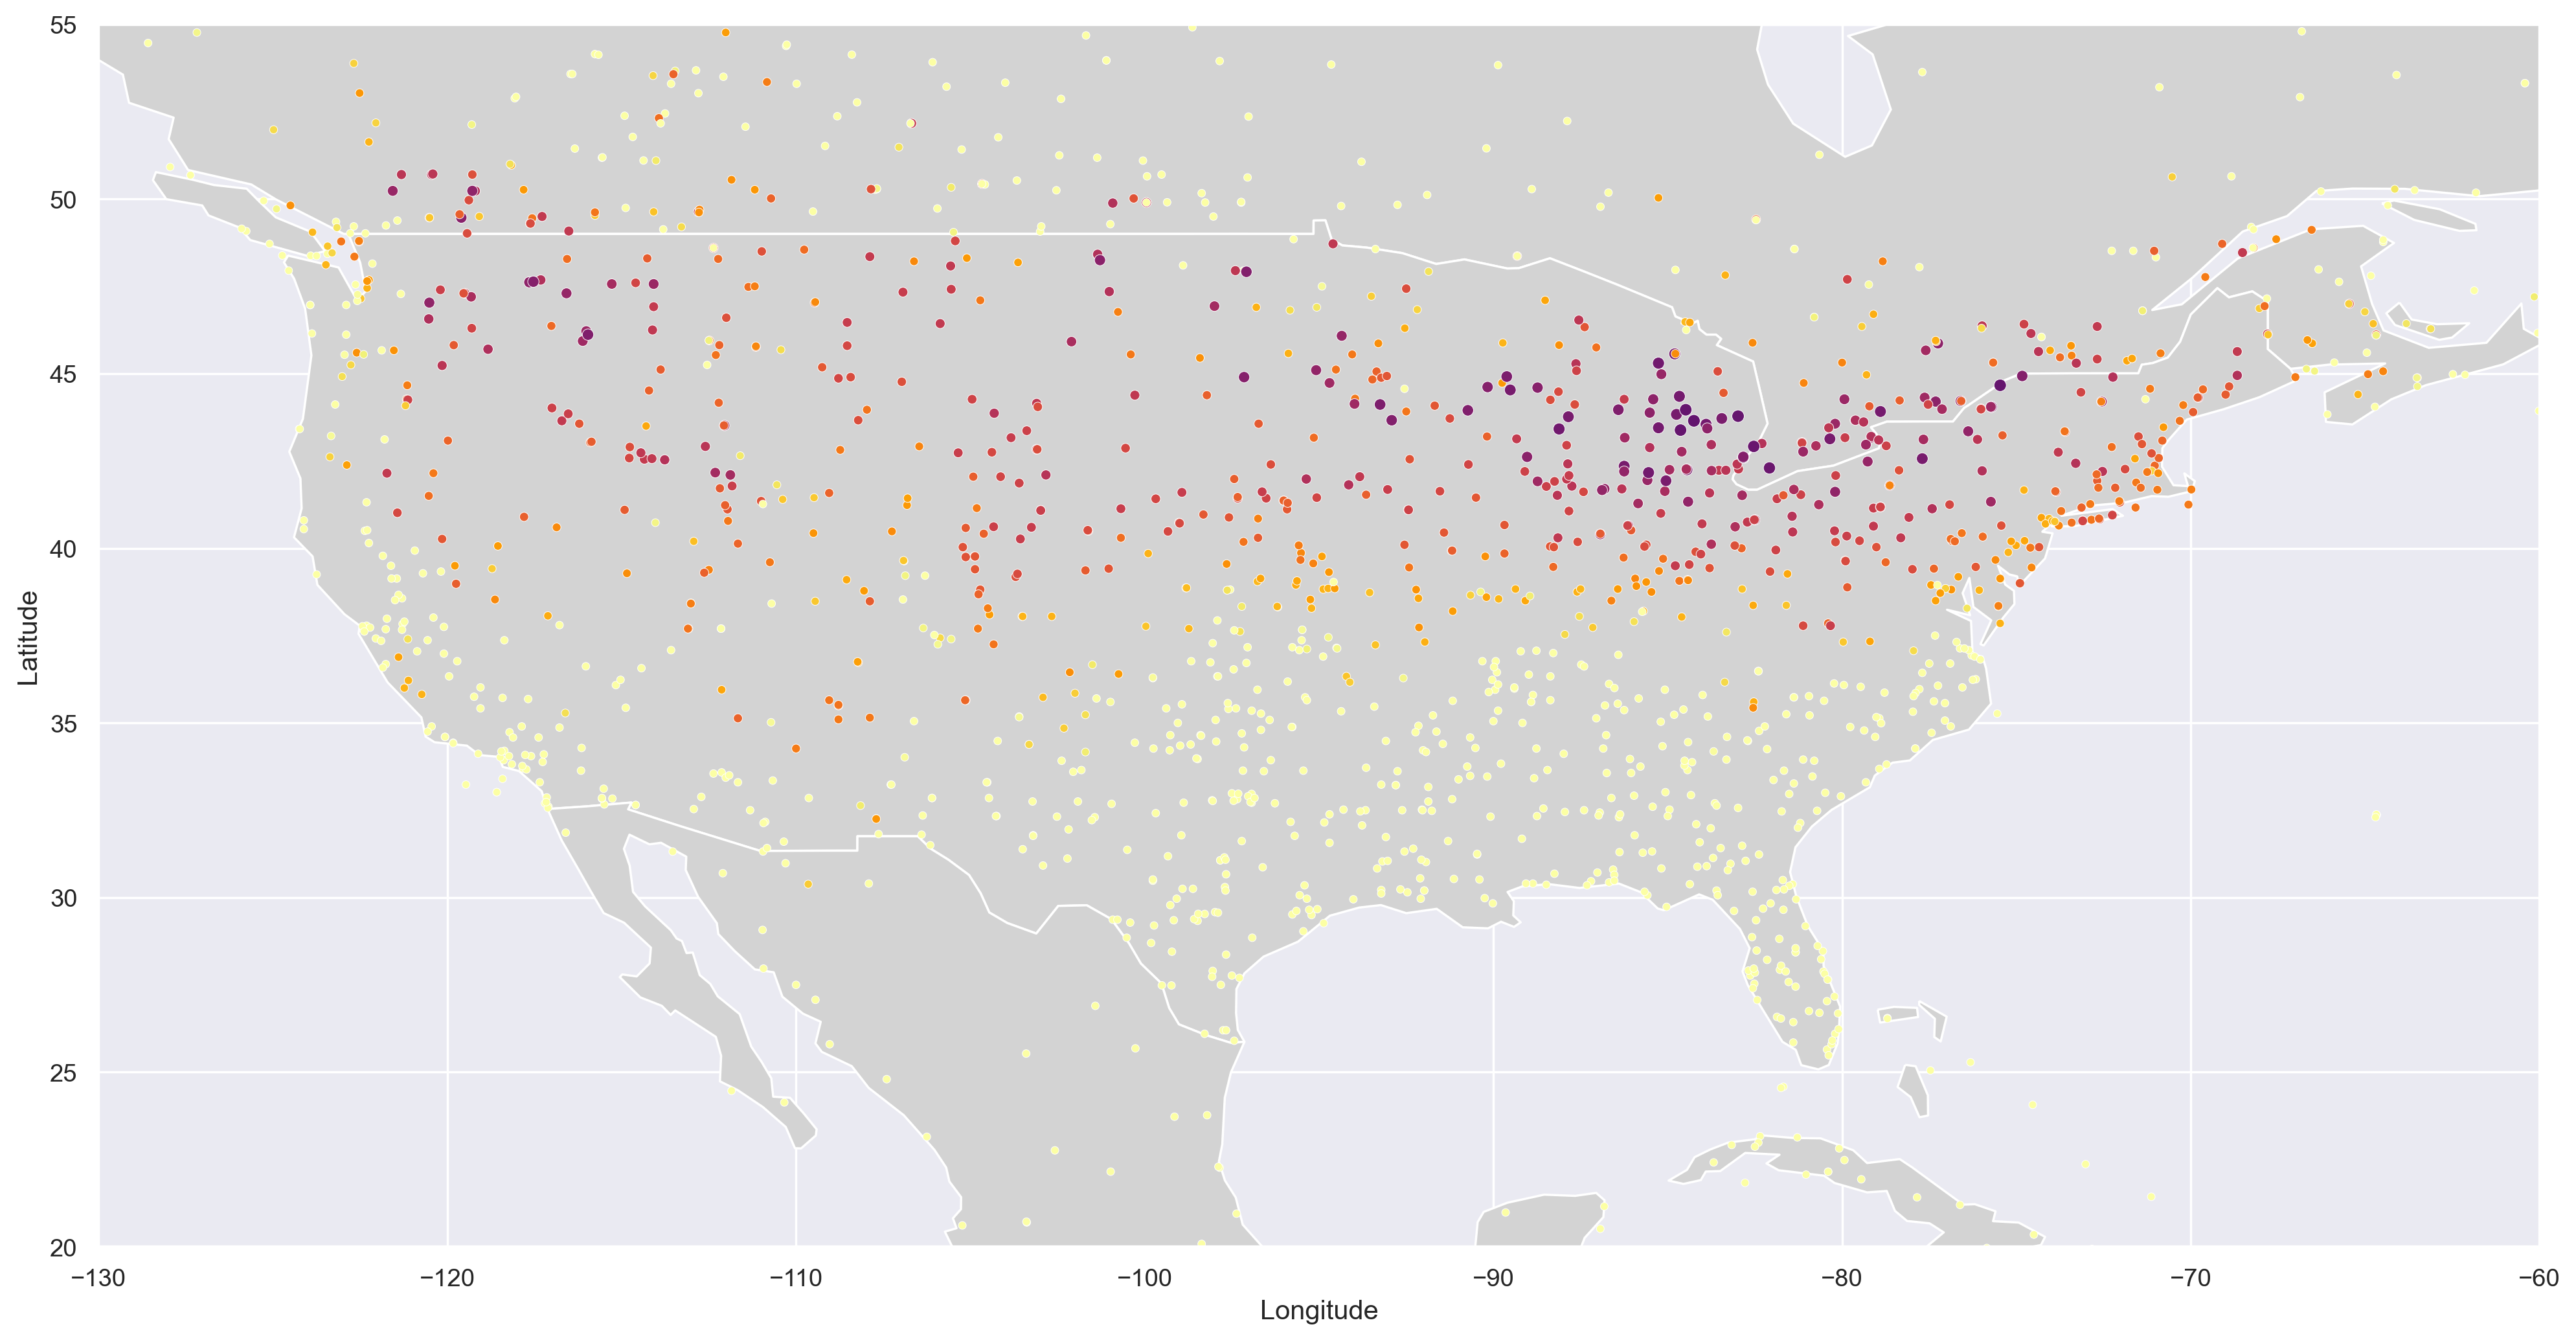

In [14]:
climate_similarity_map('Hungary/Budapest', dist_mtx, df, limits='North America')

As expected the best matches are at roughly the same latitude as my hometown, and are similarly somewhat far from the sea coast. To my surprise most of these are close to the Great Lakes (e.g., Michigan), which leads to higher humidity which is one of the main drivers of difference.

# Climate Classification
Now that we have this new metric for distance between the climates between different cities, we can try to identify clusters, i.e., climate zones.

When trying to cluster data, it is often useful to start out with a simple, easy to understand algorithm like KMeans. In our case this has the downside that we need to drop all columns with missing data (KMeans can't handle NaNs).

Since KMeans requires the number of clusters as an input parameter and we don't really know how many clusters we need, it is a good idea to try out different numbers. We do know that there are 30 Köppen climate zones, and of those 7 are very rare (i.e., they contain only a few outlier cities), so we should try cluster numbers within a factor of a few around 20.

In [9]:
def cluster_vals_to_try(target=10, searchscale=5, min_cluster_num=5):
    vals = target + searchscale/10 * np.concatenate( (-np.arange(20,50,10),-np.arange(10,20,2),np.arange(-10,10),np.arange(10,20,2),np.arange(20,50,10)) )
    vals = np.unique( vals.astype(np.int32) )
    return vals[vals>=max(min_cluster_num,2)]


KMeans
Looking for optimal number of n_cluster


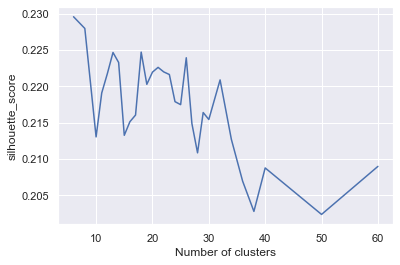

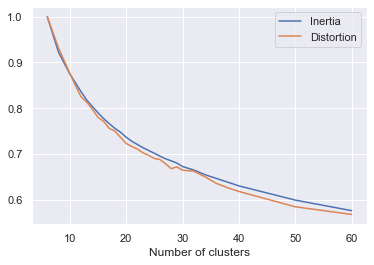

In [10]:
print('\nKMeans')
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
print('Looking for optimal number of n_cluster')
X_fit = df_red_rescaled.dropna(axis=1) #KMeans can't handle NaN, so we drop the columns that have missing data
n_cluster_vals = cluster_vals_to_try(target=20, searchscale=10)
s_scores = []; inertias=[]; distortions=[]
for n_clusters in n_cluster_vals:
    cl=KMeans(n_clusters=n_clusters, random_state=137).fit(X_fit)
    s_scores.append(silhouette_score(X_fit,cl.labels_))
    distortions.append(sum(np.min(cdist(X_fit, cl.cluster_centers_,'euclidean'), axis=1)) / X_fit.shape[0])
    inertias.append(cl.inertia_)
inertias=np.sqrt(inertias); distortions=np.array(distortions)

plt.plot(n_cluster_vals,s_scores)
plt.xlabel(r'Number of clusters'); plt.ylabel('silhouette_score');plt.show()
plt.plot(n_cluster_vals,inertias/inertias.max(), label='Inertia')
plt.plot(n_cluster_vals,distortions/distortions.max(), label='Distortion')
plt.xlabel(r'Number of clusters');  plt.legend(); plt.show() 

It seems the silhouette score does not change significantly in the range we probed, however both inertia and distortion starts leveling off between 20 and 30. For now let's use 20 as our fiducial cluster number.

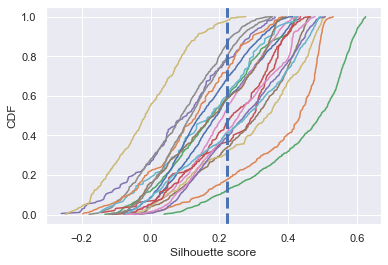

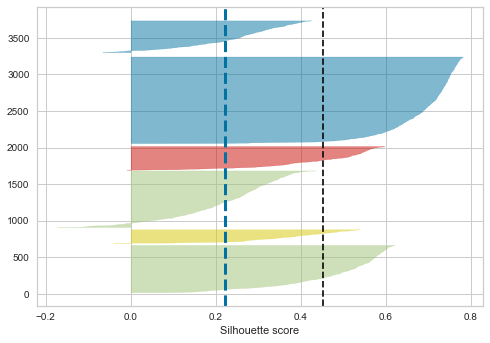

In [11]:
#Show silhouette CDF for a specific choice
from sklearn.cluster import KMeans
n_clusters=20
X_fit = df_red_rescaled.dropna(axis=1) #KMeans can't handle NaN, so we drop the columns that have missing data
cl=KMeans(n_clusters=n_clusters, random_state=137).fit(X_fit)
labels = cl.labels_
df['label'] = labels.astype(str) #if the label is kept as a number than seaborn will use a sequential colorscheme
silhouette_score_all = silhouette_samples(X_fit,labels)
silhouette_integral = np.zeros(n_clusters); integral_range = np.linspace(-1,1,100)
for label in range(n_clusters):
    s_vals = np.sort(silhouette_score_all[labels==label])
    CDF = np.cumsum(np.ones_like(s_vals)); CDF /= CDF.max() 
    silhouette_integral[label] = np.trapz(np.interp(integral_range, s_vals, CDF, left=0, right=1),integral_range)
    plt.plot(s_vals, CDF, label='cluster %d'%(label))
plt.axvline(x = silhouette_score(X_fit,cl.labels_), color = 'b',lw=3, linestyle='--')
plt.xlabel('Silhouette score'); plt.ylabel('CDF'); plt.show() #plt.legend(); 

#Pick best and worst clusters
import yellowbrick.cluster
ranked_order = np.argsort(-silhouette_integral)
best_and_worst_cl = np.append(ranked_order[:3],ranked_order[-3:])
visualizer = yellowbrick.cluster.SilhouetteVisualizer(cl, colors='yellowbrick');
visualizer.fit(X_fit[np.isin(cl.labels_,best_and_worst_cl)],)
plt.axvline(x = silhouette_score(X_fit,cl.labels_), color = 'b', linestyle='--', lw=3) 
plt.xlabel('Silhouette score'); plt.show()


The top plot shows the cumulative distribution function (CDF) of the silhouette scores within each cluster. In general we would want the lines to follow roughly the same track. Most of our 20 clusters do satisfy that, although we do have several outliers. The bottom plot concentrates on these outliers.
Using these we can try out various values for the number of clusters in the range we identified from the distrotrion and inertia plots before. For now let us keep n_clusters=20.

Now that we have a clustering let us plot it on the world map and compare with the Köppen climate map that is often used to describe climates. We find that our clustering did recover quite a few climate zones from the Köppen classification (e.g., deserts, tundra). We don't expect a perfect match, since the Köppen classification only uses seasonal temperature and precipitation, while we used over a 100 data columns.

C:\Users\gusze\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


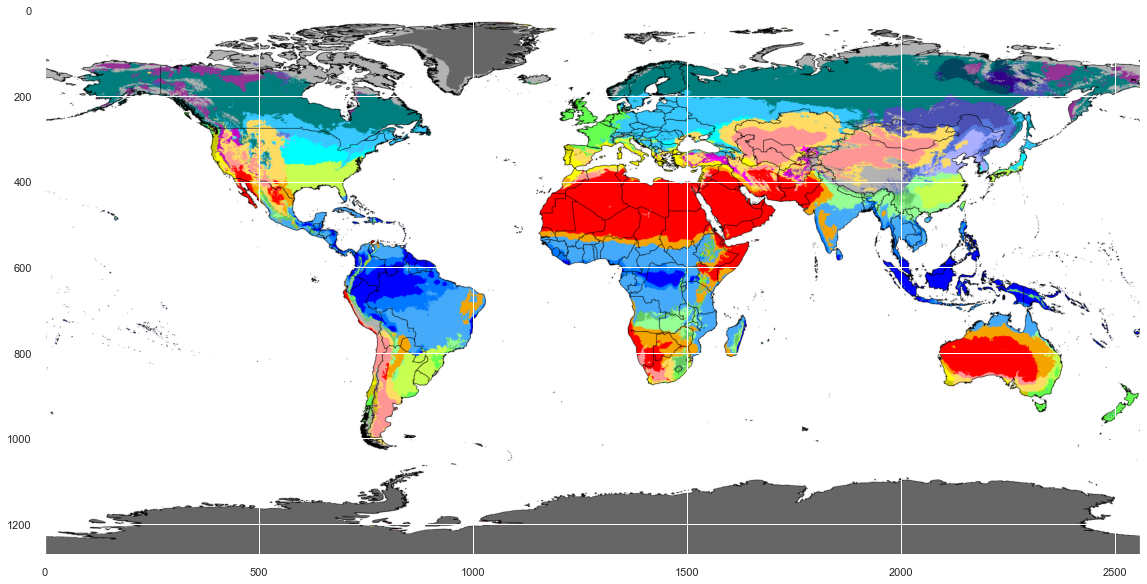

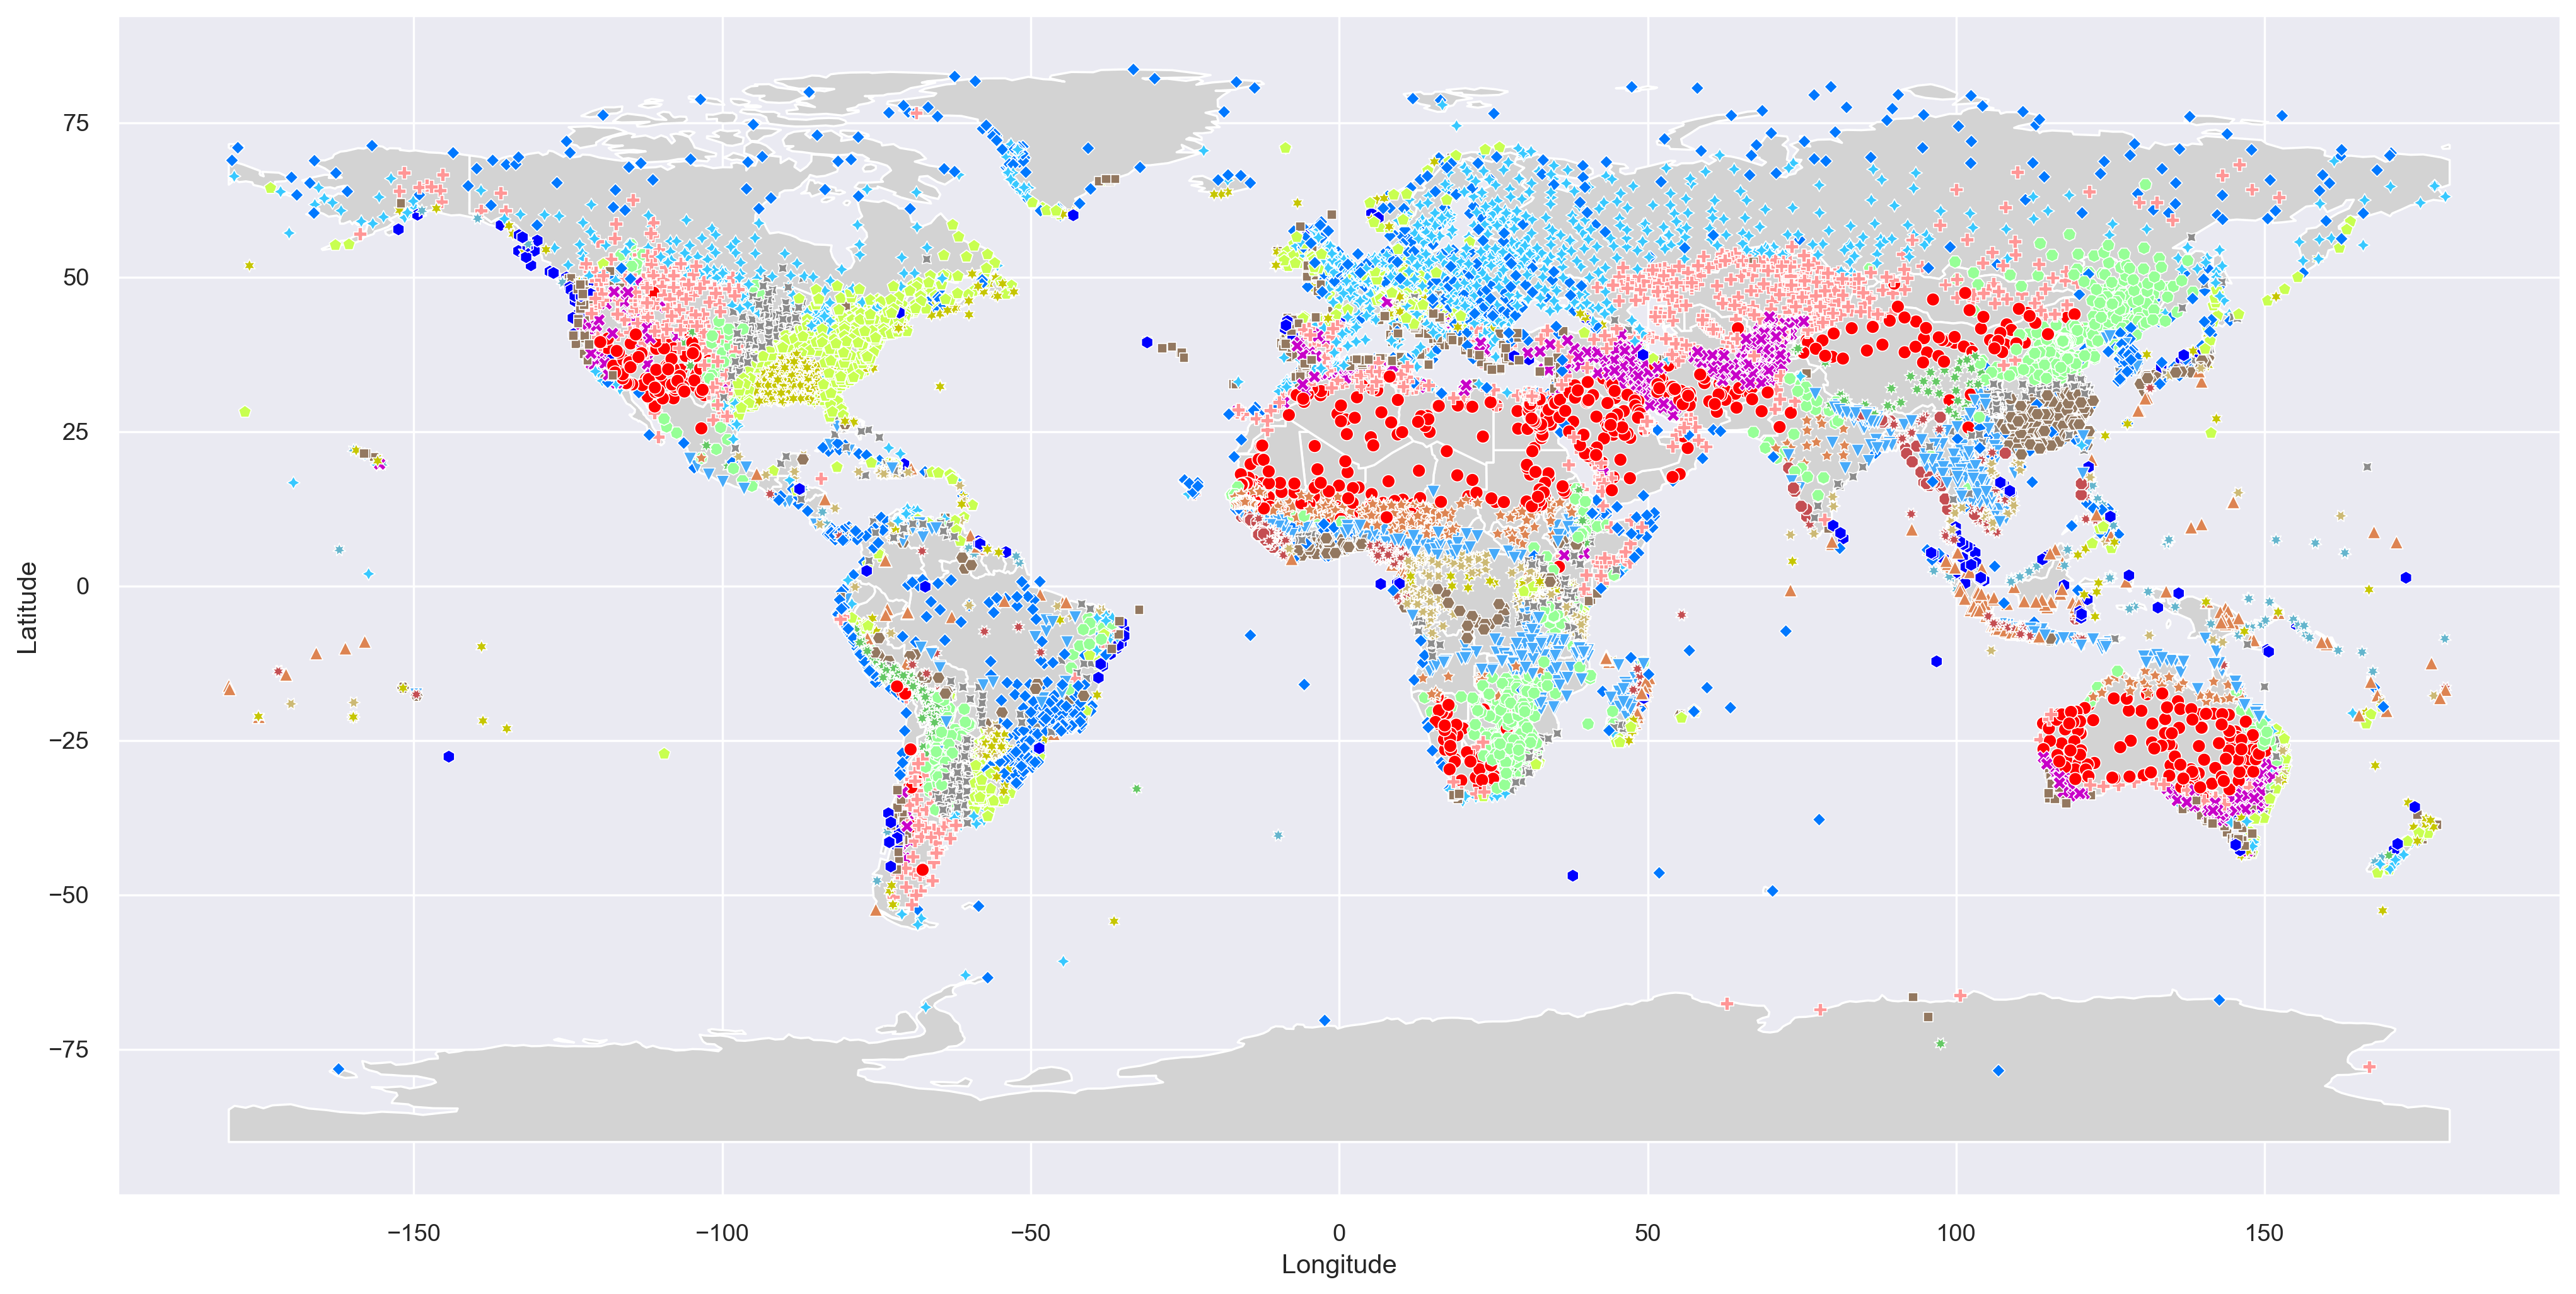

In [15]:
#Load the Köppen climate map
fig, ax = plt.subplots(figsize=(20, 10))
koppen_map = plt.imread("Koppen-Geiger_Climate_Classification_Map.png");
ax.imshow(koppen_map);

#Let's show our clustering map
fig, ax = plt.subplots(figsize=(20, 10),dpi=250)
worldmap.plot(color="lightgrey", ax=ax)
sns.scatterplot(data=df,x='Longitude',y='Latitude',hue='label',style='label', palette=map_to_koppen_colors(df)); 
plt.legend([],[], frameon=False); plt.show()
#print_label_pop_stat(labels, sort_results=True)

## Bonus: Embedding 
Embedding into a lower dimensional space for better visualization of data and final clustering.

In [13]:
from sklearn.manifold import TSNE 
X_embed  = TSNE(n_components=2,perplexity=70.0, random_state=137,\
                learning_rate='auto').fit_transform(df_red_rescaled.dropna(axis=1)) #TSNE can't handle NaN columns
#sns.scatterplot(x=X_embed[:,0],y=X_embed[:,1]); plt.show() #Need to experiment with perplexity values to get better mapping

C:\Users\gusze\anaconda3\lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:52: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "


C:\Users\gusze\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


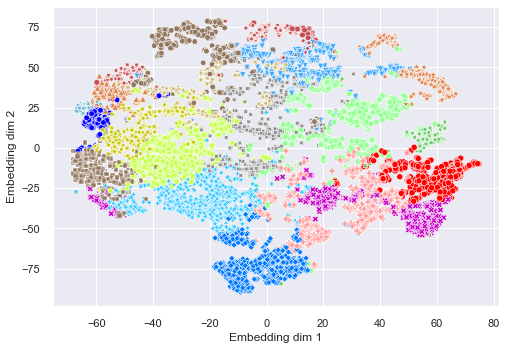

In [16]:
sns.scatterplot(x=X_embed[:,0],y=X_embed[:,1],hue=df['label'], style=df['label'],palette=map_to_koppen_colors(df)); 
plt.xlabel('Embedding dim 1'); plt.ylabel('Embedding dim 2'); plt.legend([],[], frameon=False); plt.show()